# CMU Machine Learning with Large Datasets
## Homework 4 - Machine Learning at Scale

Note that we've included code that does data loading and preparation for you. You could take a brief look to learn about how to specify a schema when loading data, or just run them all and start from "Part B Begins" after adding your S3 bucket name to cmd 8.

Note that we will not be autograding this notebook because of the open-ended nature of it (although you will have to submit this notebook). To make grading easier and to learn about your thought process, throughout the notebook, we include questions you have to anwswer in your writeup. Whenver this happens, there is a ✰ symbol.

### 0. Start a Spark Session and Install Libraries

In [1]:
# You are highly recommended to select the "PySpark" kernel instead of python kernel,
# Otherwise you need to modify this cell to get pyspark working.

from pyspark.sql import *

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1710294118291_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 3

Throughout this assignment, you will be generating plots. `Matplotlib` and other useful Python libraries do not come pre-installed on the cluster. Therefore, you will have to ssh into your master node (think about why it should be the master) using your keypair created earlier and install `matplotlib`. You might have to do this later again for other libraries you use, e.g. `Pandas`.

Run the below cell to ensure you installation was successful. If an error occurs, you might want to double check your installation.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
'''
Note : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nNote : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.\n'

### 1. Data Loading and Preparation

Earlier, we have extracted relevant features from and converted format of the full raw Million Song Dataset. We now want to load our converted dataset from the S3 Storage.

Note that although you can load all chunks of the dataset using `*`, we recommend you only load in a subset while developing so that processing takes shorter time when you are just verifying your ideas. Be sure to add your own S3 bucket name to cmd 8.

In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType([StructField('song_hotttnesss', DoubleType(), True),
                       StructField('artist_familiarity', DoubleType(), True),
                       StructField('artist_hotttnesss', DoubleType(), True),
                       StructField('artist_id', StringType(), True),
                       StructField('artist_latitude', DoubleType(), True),
                       StructField('artist_location', StringType(), True),
                       StructField('artist_longitude', DoubleType(), True),
                       StructField('artist_name', StringType(), True),
                       StructField('title', StringType(), True),
                       StructField('danceability', DoubleType(), True),
                       StructField('duration', DoubleType(), True),
                       StructField('end_of_fade_in', DoubleType(), True),
                       StructField('energy', DoubleType(), True),
                       StructField('key', DoubleType(), True),
                       StructField('key_confidence', DoubleType(), True),
                       StructField('loudness', DoubleType(), True),
                       StructField('mode', DoubleType(), True),
                       StructField('mode_confidence', DoubleType(), True),
                       StructField('start_of_fade_out', DoubleType(), True),
                       StructField('tempo', DoubleType(), True),
                       StructField('time_signature', DoubleType(), True),
                       StructField('time_signature_confidence', DoubleType(), True),
                       StructField('artist_terms', StringType(), True),
                       StructField('artist_terms_freq', StringType(), True),
                       StructField('artist_terms_weight', StringType(), True),
                       StructField('year', DoubleType(), True)]
                   )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#--------------------------------------------------------------------
#Set to False after writing your code and run end-to-end on full data
#--------------------------------------------------------------------
load_subset = False
#----------------------------
#Add your s3 bucket name below:
#----------------------------
s3_bucket_name = 'hw4msd'

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 581965 records

Inspect the `df` we just created by running the below cell:

In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

<div align="center">
    <h1>------------------- Part B Begins ------------------- </h1>
</div>

### 2. Exploratory Data Analysis

Now we have our data mostly ready. It's a good time to take some deeper look to better understand what we are dealing with here.

First, show summary statistics of the features using `.summary()`. Hint: because we have many features, the output might be too long for a single line. The simplest way to resolve this mess is to copy paste the output to some editor (e.g. vscode) and check the result. Another way is you could select only a few features to print at a time so that things could fit into one line.

In [6]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'danceability', 'duration', 'end_of_fade_in', 'energy', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'year']

In [7]:
# YOUR CODE HERE

detailed_summary = df.select('song_hotttnesss','artist_familiarity','artist_hotttnesss','artist_id','artist_latitude').summary()
detailed_summary.show()

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------------------+-------------------+------------------+---------------+
|summary|    song_hotttnesss|artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|
+-------+-------------------+------------------+-------------------+------------------+---------------+
|  count|             581965|            581965|             581965|            581965|         581965|
|   mean|0.35605103956149353|               NaN|    0.3989411270241|              null|            NaN|
| stddev|0.23444090117416477|               NaN|0.11268873629244636|              null|            NaN|
|    min|                0.0|               0.0|                0.0|AR002UA1187B9A637D|      -51.80058|
|    25%|0.21508031850922793|0.5049286820668493| 0.3528159641775416|              null|       43.64856|
|    50%| 0.3775316449767025| 0.582691083843642| 0.3994315443110678|              null|            NaN|
|    75%| 0.5319846094668594|0.6591286334605991| 0.4560945961898

In [8]:
detailed_summary = df.select('artist_location', 'artist_longitude', 'artist_name', 'title', 'danceability', 'duration').summary()
detailed_summary.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+----------------+-----------+--------------------+------------+------------------+
|summary|   artist_location|artist_longitude|artist_name|               title|danceability|          duration|
+-------+------------------+----------------+-----------+--------------------+------------+------------------+
|  count|            312640|          581965|     581965|              581963|      581965|            581965|
|   mean|162.31768953068593|             NaN|   Infinity|                 NaN|         0.0| 247.4803460953149|
| stddev|203.07901692071232|             NaN|        NaN|                 NaN|         0.0|118.77363977981476|
|    min|                  |       -162.4365|        !!!|Ia Oe E Ka La ...|         0.0|             0.522|
|    25%|             100.0|       -61.67671|      311.0|                29.0|         0.0|         183.27465|
|    50%|             104.0|             NaN|      702.0|               415.0|         0.0|         230.00771|
|

In [9]:
detailed_summary = df.select('end_of_fade_in', 'energy', 'key', 'key_confidence', 'loudness', 'mode').summary()
detailed_summary.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------+-----------------+------------------+------------------+-------------------+
|summary|    end_of_fade_in|energy|              key|    key_confidence|          loudness|               mode|
+-------+------------------+------+-----------------+------------------+------------------+-------------------+
|  count|            581965|581965|           581965|            581965|            581965|             581965|
|   mean|0.8335579218681616|   0.0|5.316178808003918|0.4447183301401297|-9.705873464899101| 0.6650262472829122|
| stddev| 3.434451678820448|   0.0|3.592772242009455|0.2765275660212384| 4.969266765337609|0.47198169508088667|
|    min|               0.0|   0.0|              0.0|               0.0|           -58.178|                0.0|
|    25%|               0.0|   0.0|              2.0|             0.216|           -12.148|                0.0|
|    50%|             0.194|   0.0|              5.0|             0.464|            -8.595|             

In [10]:
detailed_summary = df.select('mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence').summary()
detailed_summary.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------------------+------------------+------------------+-------------------------+
|summary|    mode_confidence| start_of_fade_out|             tempo|    time_signature|time_signature_confidence|
+-------+-------------------+------------------+------------------+------------------+-------------------------+
|  count|             581965|            581965|            581965|            581965|                   581965|
|   mean|  0.475581139759264|238.34107476910106|124.69398340278208| 3.615208818399732|       0.5190131227822978|
| stddev|0.19236110668476658|116.63113061745919| 34.97206548717261|1.1998028258069109|      0.37036982932953905|
|    min|                0.0|             0.522|               0.0|               0.0|                      0.0|
|    25%|               0.36|           175.508|            98.498|               3.0|                    0.138|
|    50%|              0.486|           220.677|           122.063|               4.0|          

In [11]:
detailed_summary = df.select('artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'year').summary()
detailed_summary.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----------------+--------------------+------------------+
|summary|        artist_terms|artist_terms_freq| artist_terms_weight|              year|
+-------+--------------------+-----------------+--------------------+------------------+
|  count|              581965|           581965|              581965|            581965|
|   mean|                null|             null|                null|1190.3304253692233|
| stddev|                null|             null|                null|  981.474553503066|
|    min|["rock 'n roll", ...|       [0.0, 0.0]|[1.0, 0.219892937...|               0.0|
|    25%|                null|             null|                null|               0.0|
|    50%|                null|             null|                null|            1992.0|
|    75%|                null|             null|                null|            2004.0|
|    max|                  []|               []|                  []|            2011.0|
+-------+------------

Now looking at the statistics, `danceability` and `energy` appear strange. ✰2.3(a) Explain why these features seem problematic in your writeup.

Now we would like to make some histogram plots to inspect the distribution of feature values. 

✰2.3(b) Plot histograms for `'song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'duration', 'tempo', 'year'`. 

Note that one of these features may appear weird. 

✰2.3(c) Explain what is weird about `year`'s distribution and what might cause this. Describe how you could filter `year` to make its histogram look more balanced. Hint: Choose a threshold and filter the `year` values.

✰2.3(d) Do it and include the new plot of this feature into your writeup.

Note: you may want to use the spark magic commands `%matplot plt` to show the plot.

In [12]:
# YOUR CODE HERE

pandas_df = df.select('song_hotttnesss','artist_familiarity','artist_hotttnesss','duration','tempo','year').toPandas()

# Plotting histograms for each feature
plt.figure(figsize=(15, 10))  

# Create a loop to generate histogram for each feature
for i, feature in enumerate(['song_hotttnesss','artist_familiarity','artist_hotttnesss','duration','tempo','year']):
    plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns, subplot index starting from 1
    plt.hist(pandas_df[feature], bins=50, alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

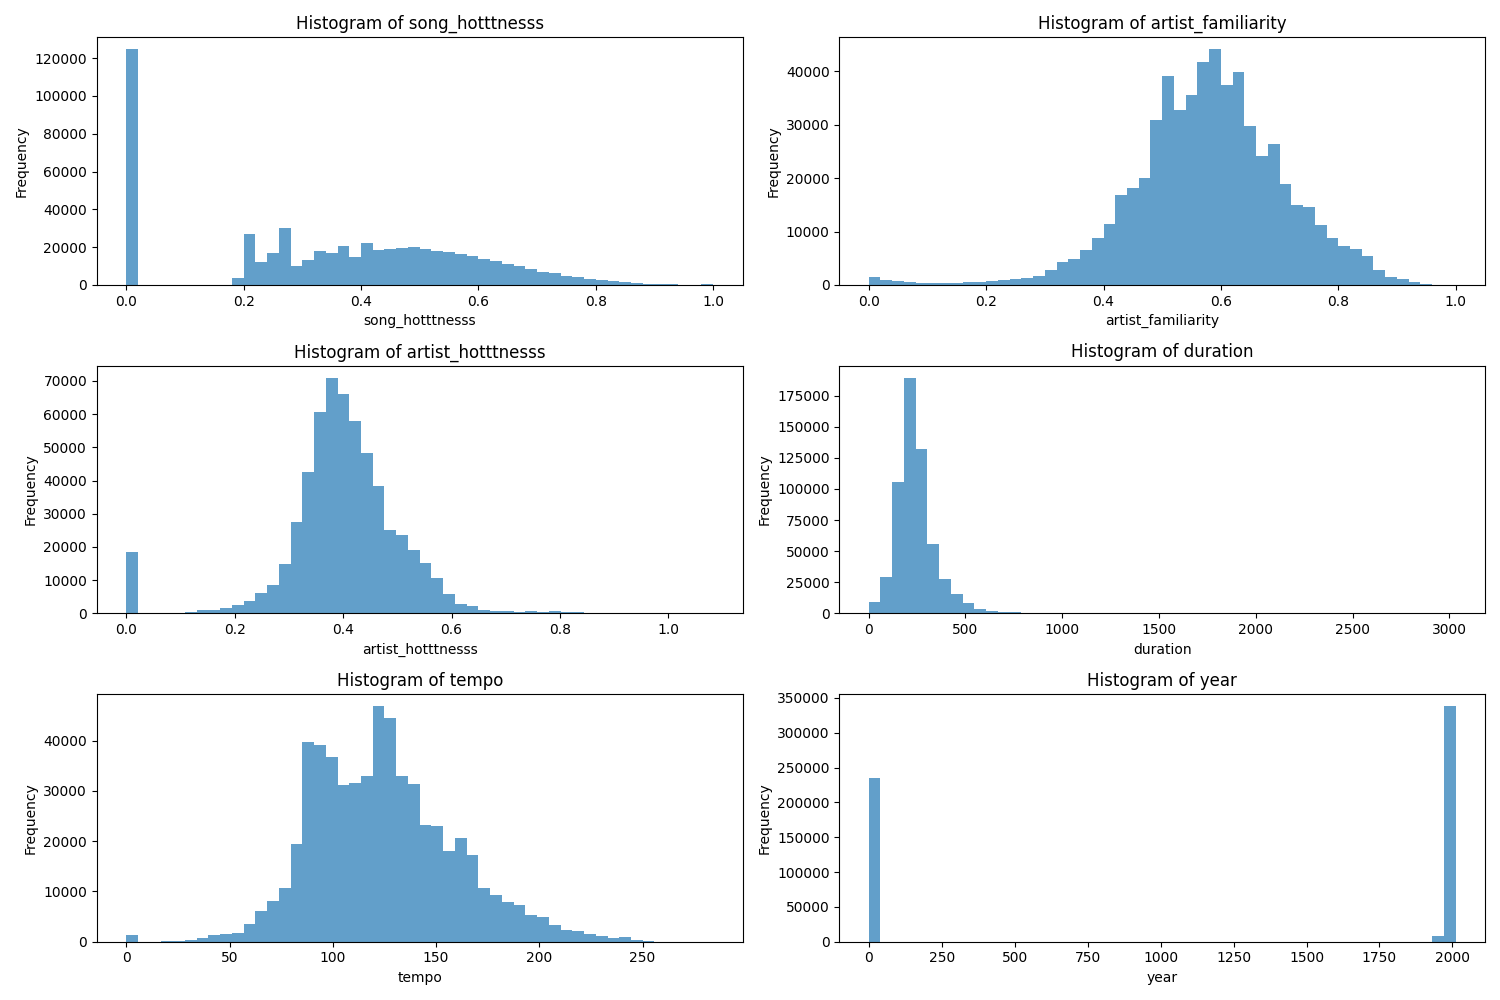

In [13]:
%matplot plt

In [14]:
# YOUR CODE HERE

pandas_df = df.select('song_hotttnesss','artist_familiarity','artist_hotttnesss','duration','tempo','year').toPandas()
pandas_df = pandas_df[pandas_df['year'] > 1920]

# Plotting histograms for each feature
plt.figure(figsize=(15, 10))  

# Create a loop to generate histogram for each feature
for i, feature in enumerate(['song_hotttnesss','artist_familiarity','artist_hotttnesss','duration','tempo','year']):
    plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns, subplot index starting from 1
    plt.hist(pandas_df[feature], bins=50, alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

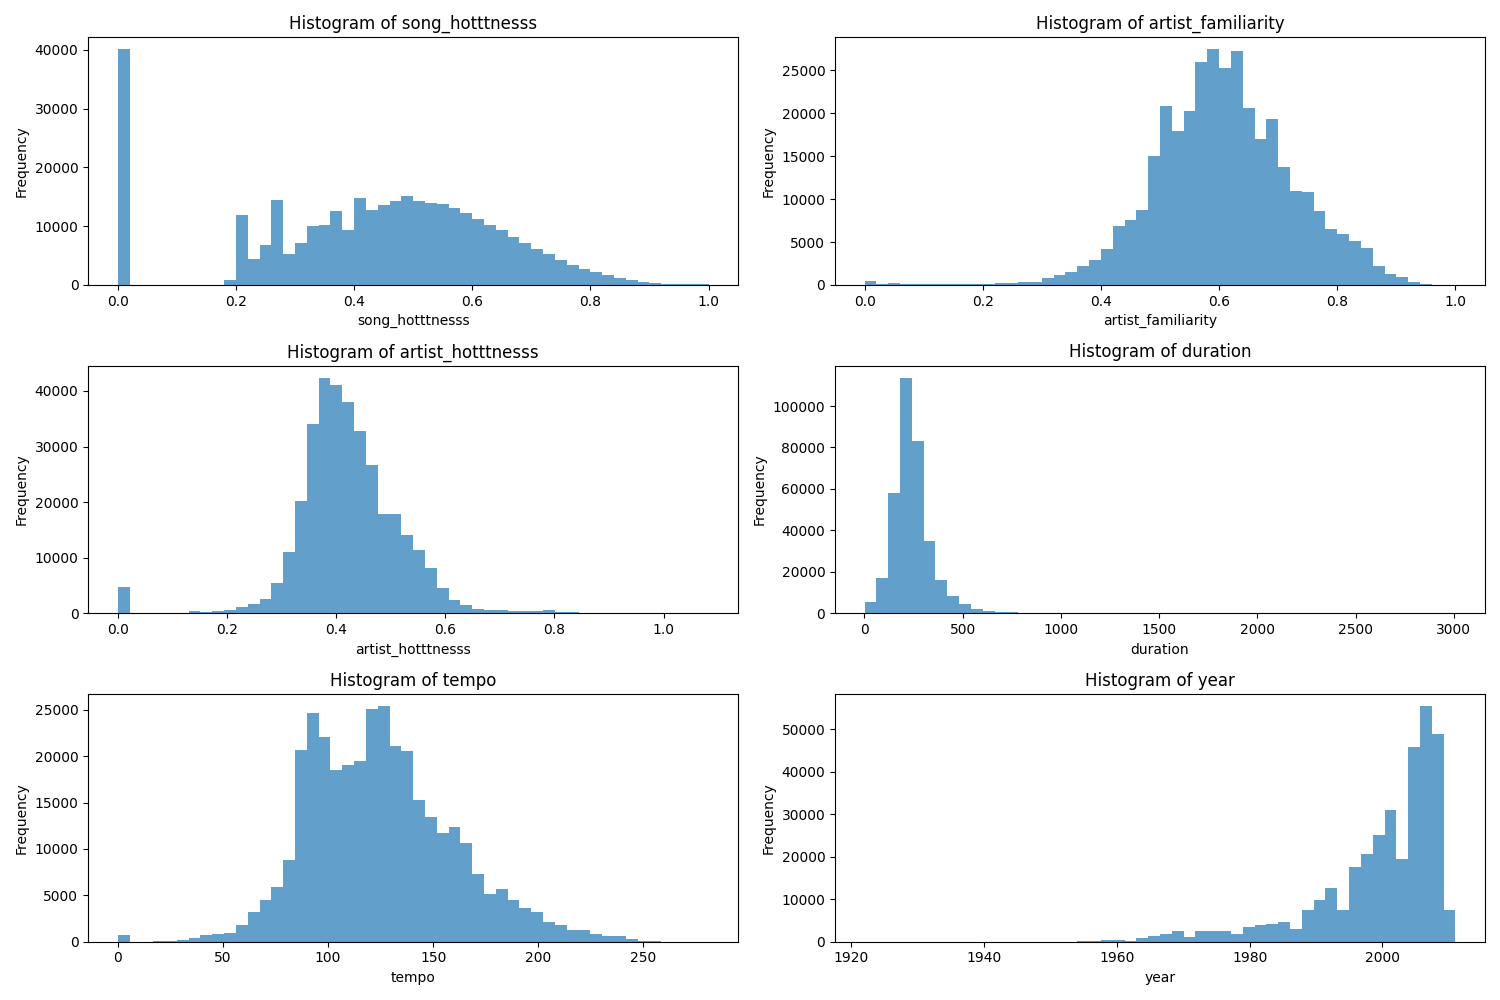

In [15]:
%matplot plt

Some scatter pair plots would also be interesting to see the correlation between features. ✰2.3(e) Include the plots of the following pairs of features and describe your findings (e.g. what patterns you observe) in your writeup.
- `song_hotttnesss` against `artist_familiarity`
- `artist_latitude` against `artist_longitude`
- `song_hotttnesss` against `year`

Plotting all data points might explode matplotlib. Think about what simple technique you could use to visualize large datasets while retaining data distribution. ✰2.3(f) In your writeup, briefly describe what you did.

In [16]:
# YOUR CODE HERE

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['song_hotttnesss'], pandas_df['artist_familiarity'], alpha=0.5)
plt.title('song_hotttnesss vs artist_familiarity')
plt.xlabel('song_hotttnesss')
plt.ylabel('artist_familiarity')
plt.show()
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

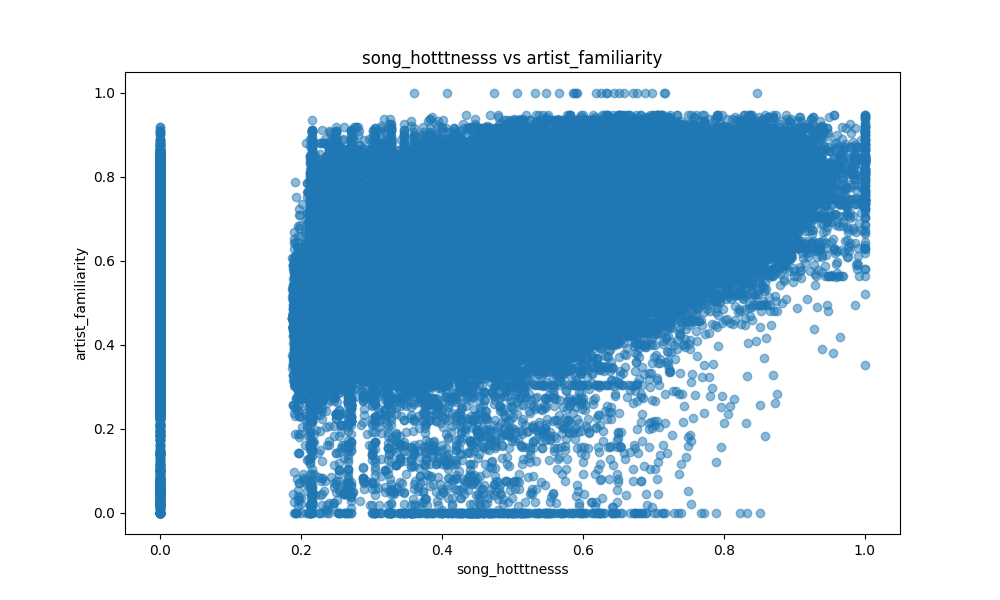

In [17]:
%matplot plt

In [18]:
artist_df = df.select('artist_latitude','artist_longitude').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(artist_df['artist_latitude'], artist_df['artist_longitude'], alpha=0.5)
plt.colorbar(label='Density')
plt.title('artist_latitude vs artist_longitude')
plt.xlabel('artist_latitude')
plt.ylabel('artist_longitude')
plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

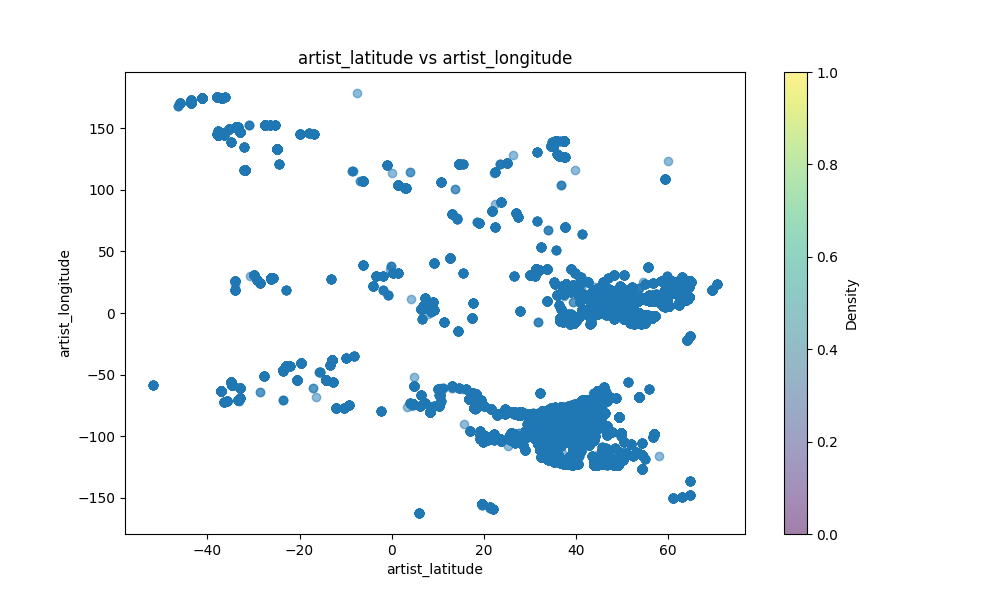

In [19]:
%matplot plt

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['song_hotttnesss'], pandas_df['year'], alpha=0.5)
plt.title('song_hotttnesss vs year')
plt.xlabel('song_hotttnesss')
plt.ylabel('year')
plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

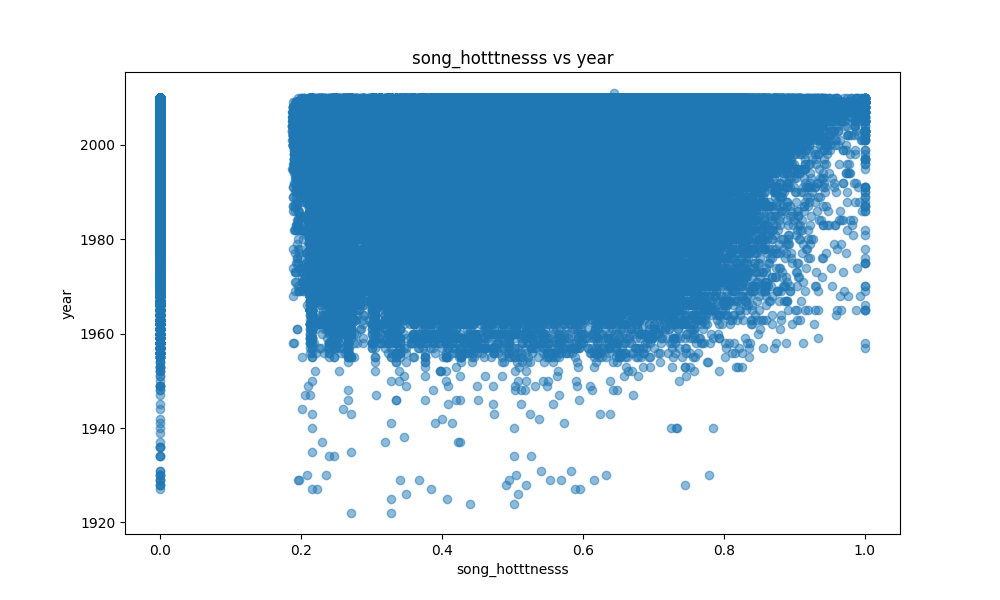

In [21]:
%matplot plt

### 3. Data Cleaning

From 2, you should have had a basic understanding of the dataset. In this cleaning step, we are dropping `energy` and `danceability` features. 

✰2.4(a) In your writeup, justify why we are doing this.

In [22]:
# YOUR CODE HERE



# Drop the 'energy' and 'danceability' columns
df_dropped = df.drop('energy', 'danceability')

# Filter out rows where 'year' is less than or equal to 1920
df_filtered = df_dropped.filter(df_dropped['year'] > 1920)



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For simplicity, we are dropping `year` values that are less or equal to 1920. Print out the number of samples before and after dropping these rows. 

✰2.4(b) In your writeup, compare these two numbers and explain the advantages and potential problem of doing this step. What other techniques could you use to potentially do better?

In [23]:
# YOUR CODE HERE
# Print the number of samples before dropping
initial_count = df.count()
print(f"Number of samples before dropping: {initial_count}")

# Print the number of samples after dropping these rows
final_count = df_filtered.count()
print(f"Number of samples after dropping: {final_count}")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of samples before dropping: 581965
Number of samples after dropping: 346444

Now, let's do an NaN check to see if there are other problematic features. Print the number of entries that contain NaN for each feature. 

Hint: use pyspark sql `count(when(isnull(...)))` to count total Null entries for a feature. Replace `isnull` with `isnan` to count nan entries.

In [24]:
# count na
from pyspark.sql.functions import isnan, when, count, isnull

# YOUR CODE HERE

nan_counts = {column: df_filtered.select(count(when(isnan(column), column)).alias(column)).collect()[0][column] for column in df_filtered.columns}

# Print the number of NaN entries for each feature
for column, nan_count in nan_counts.items():
    print(f"{column}: {nan_count} NaN entries")

    

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

song_hotttnesss: 0 NaN entries
artist_familiarity: 1 NaN entries
artist_hotttnesss: 0 NaN entries
artist_id: 0 NaN entries
artist_latitude: 219399 NaN entries
artist_location: 0 NaN entries
artist_longitude: 219399 NaN entries
artist_name: 0 NaN entries
title: 1 NaN entries
duration: 0 NaN entries
end_of_fade_in: 0 NaN entries
key: 0 NaN entries
key_confidence: 0 NaN entries
loudness: 0 NaN entries
mode: 0 NaN entries
mode_confidence: 0 NaN entries
start_of_fade_out: 0 NaN entries
tempo: 0 NaN entries
time_signature: 0 NaN entries
time_signature_confidence: 0 NaN entries
artist_terms: 0 NaN entries
artist_terms_freq: 0 NaN entries
artist_terms_weight: 0 NaN entries
year: 0 NaN entries

We should see two features that contain (a lot of) `nan` in them. ✰2.4(c) Which two are they? 

For simplicity, we are dropping all records with `nan` in these two features. Note that this drops a significant proportion of our dataset. Since we have a lot of data to fit some rather simple models, this might be ok. 

However, do note that this is not usually desirable in the real-word because we always want to retain as much data as possible, especially when training larger, more complex models. ✰2.4(d) In your writeup, explain what possible techniques could you employ to deal with this situation. Discuss the pros and cons of your proposed solution.

In [25]:
# YOUR CODE HERE

# Drop rows where either 'artist_latitude' or 'artist_longitude' contain NaN values
df_cleaned = df_filtered.na.drop(subset=['artist_latitude', 'artist_longitude'])


# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

✰2.4(e) Finally in your writeup, report the percentage of records that survived our very aggressive data cleaning.

In [26]:
# counting code
final_count = df_cleaned.count()
percentage = final_count/df_filtered.count()*100
print(f"percentage: {percentage}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

percentage: 36.67115031577975

### 4. Baseline

Now we have the data (almost) ready to do some preliminary modeling! 

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average. 

✰2.5(a) Explain in your writeup why treating this as a classification problem (instead of a regression problem) might be a sensible choice. 

Then, assign labels to the dataset with the above definition of "popularity".

In [27]:
from pyspark.sql.functions import avg, col, expr, when

# assign labels
# YOUR CODE HERE

# Calculate the average song_hotttnesss
average_hotttnesss = df_cleaned.agg(avg("song_hotttnesss")).collect()[0][0]

# Assign labels based on the average song_hotttnesss
df_labeled = df_cleaned.withColumn('popular', when(col('song_hotttnesss') > average_hotttnesss, 1).otherwise(0))


# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's take a look at how balanced the two classes are. ✰2.5(b) Report what percentage of songs are assigned the "popular" label.

In [28]:
# YOUR CODE HERE
# Count the total number of songs and the number of popular songs
total_songs = df_labeled.count()
popular_songs_count = df_labeled.filter(col('popular') == 1).count()

# Calculate the percentage of popular songs
popular_percentage = (popular_songs_count / total_songs) * 100

print(f"Percentage of songs labeled as 'popular': {popular_percentage:.2f}%")

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of songs labeled as 'popular': 55.99%

As how we've been dealing with the `year` feature in earlier assignments, we will shift the feature so that it starts from 0.

✰2.5(c) Explain why we want to do this.

In [29]:
# shift years
# YOUR CODE HERE
from pyspark.sql.functions import min

min_year = df_labeled.select(min(col('year'))).collect()[0][0]
# Shift the 'year' feature to start from 0
df_shifted = df_labeled.withColumn('year_shifted', col('year') - min_year).drop('year')


# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Finally, let's concatenate all features (using VectorAssembler) into a feature vector and scale it. 

✰2.5(d) Explain what scaling means and why we want to perform scaling before the learning step.

Note: we will only be using the numeric features for now. Excluding `song_hotttnesss` and the two features we dropped in the data cleaning step, there should be 19-3=16 of them.

In [30]:
# assembling vector

from pyspark.ml.feature import VectorAssembler, StandardScaler

# YOUR CODE HERE

# Identify numeric columns only
numeric_features = [column for column, dtype in df_shifted.dtypes if dtype in ['int', 'double', 'float'] and column not in ['song_hotttnesss', 'energy', 'danceability','popular']]

# Concatenate all features into a single feature vector
vector_assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
featured_df = vector_assembler.transform(df_shifted)



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# scaling

from pyspark.ml.feature import StandardScaler

# YOUR CODE HERE
# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(featured_df)
scaled_df = scaler_model.transform(featured_df)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
scaled_df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'popular', 'year_shifted', 'features', 'scaled_features']

Now let's verify the resulting feature vector is of expected length 16.

In [33]:
# change your variable/column names accordingly
l = scaled_df.select('features').take(1)[0].features
print('vector len:',len(l))
assert len(l) == 16

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 16

Now, we are really ready to fit some models. 

First, do a train-test split on the dataset, with test ratio 0.2 and seed 10605.

In [34]:
# YOUR CODE HERE
# Split the dataset into train and test sets
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=10605)

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We have to select a metric to evaluate our models on. For classification, potential choices include accuracy and AUC. ✰2.5(e) In your writeup, explain the difference between these two metrics and when AUC might be more useful than accuracy.

We will be going with AUC here. Instantiate an AUC Evaluator in the following cell.

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# YOUR CODE HERE
# Instantiate an AUC evaluator
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="popular", metricName="areaUnderROC")

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest, in the mandatory part. You have the chance go with fancier models in the last section to achieve higher accuracy to earn additional points.

Train a LR and a RF model with default hyperparameters. ✰2.5(f) Calculate the train and test AUC of both models and report them in your writeup.

In [36]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

# YOUR CODE HERE
# Instantiate the models with default parameters
lr_model_1 = LogisticRegression(featuresCol="scaled_features", labelCol="popular")

# Train the models
lr_fitted = lr_model_1.fit(train_df)


# Make predictions on the train and test datasets
lr_train_predictions = lr_fitted.transform(train_df)
lr_test_predictions = lr_fitted.transform(test_df)


# Instantiate an AUC evaluator
# auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="popular", metricName="areaUnderROC")

# Calculate and print the train and test AUC for Logistic Regression
lr_train_auc = auc_evaluator.evaluate(lr_train_predictions)
lr_test_auc = auc_evaluator.evaluate(lr_test_predictions)
print(f'Logistic Regression Train AUC: {lr_train_auc}')
print(f'Logistic Regression Test AUC: {lr_test_auc}')



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Train AUC: 0.7539806404324805
Logistic Regression Test AUC: 0.7572353736912399

In [37]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

# YOUR CODE HERE
rf_model_1 = RandomForestClassifier(featuresCol="scaled_features", labelCol="popular")
rf_fitted = rf_model_1.fit(train_df)

rf_train_predictions_1 = rf_fitted.transform(train_df)
rf_test_predictions_1 = rf_fitted.transform(test_df)

# auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="popular", metricName="areaUnderROC")

# Calculate and print the train and test AUC for Random Forest
rf_train_auc = auc_evaluator.evaluate(rf_train_predictions_1)
rf_test_auc = auc_evaluator.evaluate(rf_test_predictions_1)
print(f'Random Forest Train AUC: {rf_train_auc}')
print(f'Random Forest Test AUC: {rf_test_auc}')


# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest Train AUC: 0.7604096093388238
Random Forest Test AUC: 0.7634105569573669

### 5. Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`. In the entity resolution task of HW1, we've seen how TF-IDF could help us featurize textual data. Let's do that here as well. [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) is yet another technique (arguably simpler than TF-IDF) to featurize text features.


To get yourself familiar with both in Spark, let's treat titles and artist terms as mini documents and compute TF-IDF for `title` and BoW for `artist_terms`.

In [38]:
# tf-idf on title

from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

# YOUR CODE HERE
# Tokenize the title column
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
title_tokenized = tokenizer.transform(df_shifted)

# Compute Term Frequency (TF) using HashingTF
hashingTF = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=TF_IDF_NUM_FEATS)
title_tf = hashingTF.transform(title_tokenized)

# Compute Inverse Document Frequency (IDF)
idf = IDF(inputCol="title_tf", outputCol="title_tfidf")
idfModel = idf.fit(title_tf)
title_tfidf = idfModel.transform(title_tf)



# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.

In [39]:
from pyspark.ml.linalg import SparseVector 
# change variable/column name to yours
col_name = 'title_tfidf'
head = title_tfidf.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_tfidf=SparseVector(5, {1: 0.8022, 2: 0.6637, 3: 0.696}))

Recall that `artist_terms` should be of type string array but we have not yet interpreted from a string literal. Let's do that now. 

Hint: start by defining a UDF to convert a single string literal to type `T.ArrayType(T.StringType())`.

In [40]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T
import ast

# YOUR CODE HERE

# Define a UDF to convert a string literal to an array of strings
def string_to_array(str_literal):
    return ast.literal_eval(str_literal)

string_to_array_udf = udf(string_to_array, T.ArrayType(T.StringType()))

# Apply the UDF to convert the string literal column to an array type
df_with_array = title_tfidf.withColumn("artist_terms_array", string_to_array_udf(col("artist_terms")))


# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's do a quick check things indeed worked out.

In [41]:
# change to your variable/column names
col_name = 'artist_terms_array'
head = df_with_array.select(col_name).head()
print(head)
assert type(head[col_name]) == list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_array=['hardcore punk', 'heavy metal', 'hardcore metal', 'thrash core', 'hard rock', 'death core', 'crossover thrash', 'metalcore', 'nu metal', 'rock', 'melodic black metal', 'thrash metal', 'hardcore', 'melodic death metal', 'power metal', 'screamo', 'progressive metal', 'black metal', 'punk', 'emo', 'death metal', 'hip hop', 'rap', 'alternative rock', 'punk metal', 'united states', 'singer-songwriter', 'metal', 'american', 'new york hardcore', 'alternative', 'germany', 'indie', 'christian', '00s', 'heavy', 'new york', 'crossover', 'new york city', 'old school hardcore', 'drums', 'trash metal', 'beat down'])

Now perform BoW on the array feature you just created.

✰2.6(a) In your writeup, explain what the `vocabSize` hyperparameter means in the context of Bag-of-Words. Remember you can tune this later in the last section.

In [42]:
# BoW on artist_terms

from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10 
BOW_MIN_DF = 2
# CountVectorizer(..., vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)

# YOUR CODE HERE

# Now perform BoW on the newly created array feature
countVectorizer = CountVectorizer(inputCol="artist_terms_array", outputCol="artist_terms_bow", vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
cv_model = countVectorizer.fit(df_with_array)
df_bow = cv_model.transform(df_with_array)

# df_bow will now contain a new column "artist_terms_bow" which is the BoW representation of the artist terms

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the result of BoW is indeed a vector of length `BOW_VOCAB_SIZE`.

In [43]:
# change variable/column name to yours
col_name = 'artist_terms_bow'
head = df_bow.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == BOW_VOCAB_SIZE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_bow=SparseVector(10, {0: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 7: 1.0}))

✰2.6(b) Other than featurizing texts, what other feature engineering would you do on the dataset? Briefly describe one in your writeup.

Now with the new feature columns ready, let's assemble and scale our features once again as we did to prepare for training. 

This time, we should have 16+2=18 features with the two being TF-IDF and BoW features we just created. The total length of the resulting feature vector should be 31. ✰2.6(c) Explain where this number (31) comes from in your writeup.

In [44]:
# assembling vector

# YOUR CODE HERE

# Add the column names for TF-IDF and BoW features
feature_columns = numeric_features + ['title_tfidf', 'artist_terms_bow']

# Assemble all features into a single feature vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
df_assembled = assembler.transform(df_bow)  

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
df_assembled.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'popular', 'year_shifted', 'title_tokens', 'title_tf', 'title_tfidf', 'artist_terms_array', 'artist_terms_bow', 'assembled_features']

In [46]:
# scaling

# YOUR CODE HERE

# Scale the assembled features
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled_features = scaler_model.transform(df_assembled)


# YOUR CODE HERE
df_scaled_features.toPandas().head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   song_hotttnesss  ...                                    scaled_features
0         0.634759  ...  [6.252083359128791, 4.19023760140167, 2.553043...
1         0.000000  ...  [4.391876525267229, 3.8176683727154797, 2.9858...
2         0.489038  ...  [6.948372304724167, 5.2301583100352165, 3.1683...
3         0.376170  ...  [5.384264805262917, 4.513184448512579, 2.56266...
4         0.604094  ...  [6.725062769332288, 5.952969935681367, 2.13591...

[5 rows x 32 columns]

In [47]:
df_scaled_features.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'popular', 'year_shifted', 'title_tokens', 'title_tf', 'title_tfidf', 'artist_terms_array', 'artist_terms_bow', 'assembled_features', 'scaled_features']

Now let's verify the feature vector is of expected length 31.

In [48]:
# change your variable/column names accordingly
l = df_scaled_features.select('scaled_features').take(1)[0]['scaled_features']
print('vector len:',len(l))
assert len(l) == 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 31

### 6. Modeling with New Features

Now let's fit LR and RF on our new data. As before, first do a train-test split with test ratio 0.2 and seed 10605.

In [49]:
# YOUR CODE HERE
train_df, test_df = df_scaled_features.randomSplit([0.8, 0.2], seed=10605)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now train the LR and RF model with default hyperparameters. ✰2.7(a) Evaluate train and test AUC for each model and report them in your writeup.

In [50]:
# Logistic Regression

# YOUR CODE HERE

# AUC evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="popular", metricName="areaUnderROC")
# Logistic Regression
lr = LogisticRegression(featuresCol='scaled_features', labelCol='popular')  # Adjust 'label' to your actual label column name
lr_model = lr.fit(train_df)

# Make predictions
lr_train_predictions = lr_model.transform(train_df)
lr_test_predictions = lr_model.transform(test_df)

# Evaluate AUC for Logistic Regression
lr_train_auc = evaluator.evaluate(lr_train_predictions)
lr_test_auc = evaluator.evaluate(lr_test_predictions)

# Print the AUC scores
print(f'Logistic Regression - Train AUC: {lr_train_auc}, Test AUC: {lr_test_auc}')

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression - Train AUC: 0.7669364101133671, Test AUC: 0.769712958047239

In [51]:
lr_test_predictions.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'popular', 'year_shifted', 'title_tokens', 'title_tf', 'title_tfidf', 'artist_terms_array', 'artist_terms_bow', 'assembled_features', 'scaled_features', 'rawPrediction', 'probability', 'prediction']

In [52]:
# Random Forest

# YOUR CODE HERE
# Random Forest
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='popular')  # Adjust 'label' to your actual label column name
rf_model = rf.fit(train_df)

rf_train_predictions_2= rf_model.transform(train_df)
rf_test_predictions_2 = rf_model.transform(test_df)

# Evaluate AUC for Random Forest
rf_train_auc = evaluator.evaluate(rf_train_predictions_2)
rf_test_auc = evaluator.evaluate(rf_test_predictions_2)

print(f'Random Forest - Train AUC: {rf_train_auc}, Test AUC: {rf_test_auc}')
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - Train AUC: 0.7684641989024771, Test AUC: 0.7716418744435208

Recall that AUC is the area under the ROC curve. Now, plot the ROC curves for the four models (including two baselines) in **one single plot**. 

✰2.7(b) In your writeup:
- Include the plot (with legends)
- Explain how the ROC curve is derived and what it measures
- Explain, from the ROC curves, how do you discover which models are performing better than others, and in this case, which model performs the best.

In [53]:
# YOUR CODE HERE
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Logistic Regression ROC data
lr_summary = lr_model.summary
roc_lr = lr_summary.roc.toPandas()
fpr_lr, tpr_lr = roc_lr['FPR'], roc_lr['TPR']

lr_summary_fitted = lr_fitted.summary
roc_lr_fitted = lr_summary_fitted.roc.toPandas()
fpr_lr_fitted, tpr_lr_fitted = roc_lr_fitted['FPR'], roc_lr_fitted['TPR']

rf_summary = rf_model.summary
roc_rf = rf_summary.roc.toPandas()
fpr_rf, tpr_rf = roc_rf['FPR'], roc_rf['TPR']

rf_summary_fitted = rf_fitted.summary
roc_rf_fitted = rf_summary_fitted.roc.toPandas()
fpr_rf_fitted, tpr_rf_fitted = roc_rf_fitted['FPR'], roc_rf_fitted['TPR']

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='LR Model Featurization')
plt.plot(fpr_lr_fitted, tpr_lr_fitted, label='LR Model')
plt.plot(fpr_rf, tpr_rf, label='RF Model')
plt.plot(fpr_rf_fitted, tpr_rf_fitted, label='RF Model Featurization')

plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
roc_lr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           FPR       TPR
0     0.000000  0.000000
1     0.000045  0.001738
2     0.000090  0.003476
3     0.000180  0.005178
4     0.000337  0.006828
...        ...       ...
1013  0.994476  0.999315
1014  0.996475  0.999526
1015  0.998361  0.999824
1016  1.000000  1.000000
1017  1.000000  1.000000

[1018 rows x 2 columns]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

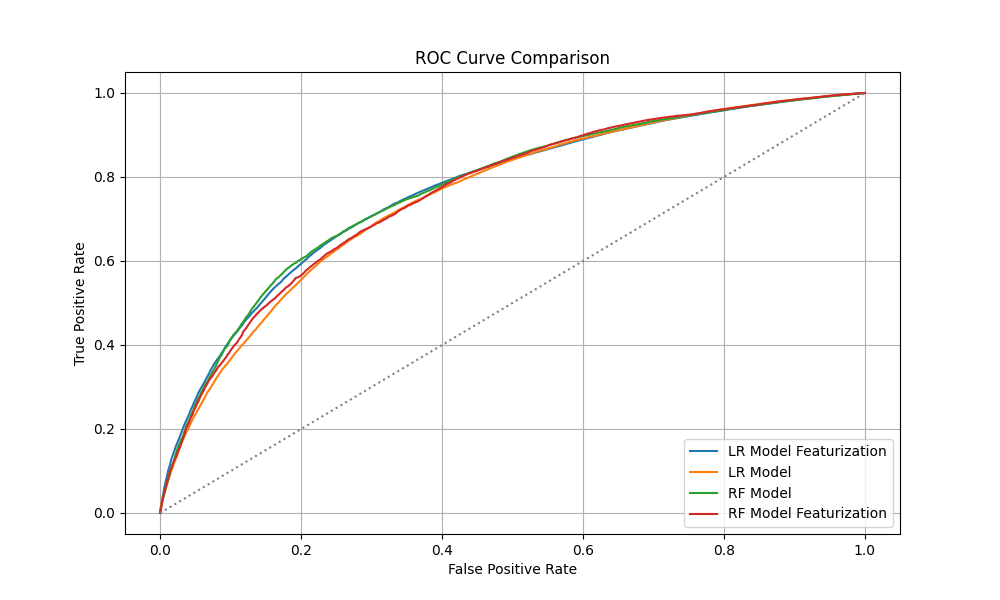

In [55]:
%matplot plt

### 7. Do Your Best

In all previous sections in this assignment and other assignments so far, we have almost specified everything you should do. You might be (and should be!) bored by now. This section gives you a chance to do whatever you want to improve the prediction AUC. 

You can do better data preprocessing, feature engineering, fit fancier models, perform hyperparameter tuning, etc. 

After you are satisfied with your model, ✰2.8 in your writeup, report 
- the hyperparameters,
- train and test AUC of your optimized model, and 
- the approach you took on top of the specified instructions to obtain this better result.

In [56]:
# have fun!
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
df_assembled = assembler.transform(df_shifted).select("features", col("popular").alias("label"))

# Initialize the GBT model
gbt = GBTClassifier(featuresCol="features", labelCol="label")

# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Evaluation through binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Cross-validation
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit the model
cvModel = cv.fit(df_assembled)

# Best model hyperparameters and AUC
bestModel = cvModel.bestModel
trainAUC = evaluator.evaluate(bestModel.transform(df_assembled))

# Assuming 'df_test' is your test DataFrame
df_test_assembled = assembler.transform(test_df).select("features", col("popular").alias("label"))

# Evaluate the best model on the test data
testAUC = evaluator.evaluate(bestModel.transform(df_test_assembled))

print(f'Train AUC: {trainAUC}')
print(f'Test AUC: {testAUC}')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC: 0.8943561228582784
Test AUC: 0.8959814472936417

In [57]:
bestParams = bestModel.extractParamMap()
bestMaxDepth = bestParams[gbt.maxDepth]
bestMaxBins = bestParams[gbt.maxBins]
bestMaxIter = bestParams[gbt.maxIter]
print(f'bestMaxDepth: {bestMaxDepth}')
print(f'bestMaxBins: {bestMaxBins}')
print(f'bestMaxIter: {bestMaxIter}')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bestMaxDepth: 10
bestMaxBins: 64
bestMaxIter: 20

### 8. Don't forget to answer the reflection question on the writeup! ✰2.9